# Imports

In [194]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import sklearn.metrics as met
from IPython.display import Image
from tensorflow import keras
from keras.layers import Input, Dense, BatchNormalization
from keras import Model
import numpy as np
import pandas as pd
from simanneal import Annealer
from inspyred.ec import ec
import random
import math
from tensorflow import keras
from tensorflow.keras.utils import *
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras
from keras import *
from keras.src.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsolutePercentageError
import gc  # Garbage collector
from scipy.stats import norm
from sklearn.metrics import roc_curve, roc_auc_score 



# Voeg libraries toe indien nodig

# Eigen functies
Als je zelfgemaakte functies gebruikt in je antwoorden plaats de functie zelf dan in de cel hieronder

In [195]:
# Plaats hier de in de antwoorden gebruikte functies die je zelf gemaakt hebt.

def trueFalse (confusion_matrix, columnnb=0):
    TP = confusion_matrix.iloc[columnnb][columnnb]
    print('TP', TP)
    TN = np.diag(confusion_matrix).sum() - TP
    print('TN:', TN)
    FP = confusion_matrix.iloc[:, columnnb].sum() - TP
    print('FP:', FP)
    FN = confusion_matrix.iloc[columnnb,:].sum() - TP
    print('FN:', FN)
    return

def accuracy(confusion_matrix):
    return np.diag(confusion_matrix).sum()/confusion_matrix.sum().sum()

def precision(confusion_matrix):
    precision = []
    n = confusion_matrix.shape[1]
    for i in range(0,n):
        TP = confusion_matrix.iloc[i][i]
        precision = precision + [TP/confusion_matrix.iloc[:, i].sum()]
    return precision

def recall(confusion_matrix):
    recall = []
    n = confusion_matrix.shape[0]
    for i in range(0,n):
        TP = confusion_matrix.iloc[i][i]
        recall = recall + [TP/confusion_matrix.iloc[i, :].sum()]
    return recall

def f_measure(confusion_matrix, beta):
    precisionarray = precision(confusion_matrix)
    recallarray = recall(confusion_matrix)
    fmeasure=[]
    n = len(precisionarray)
    for i in range(0,n):
        p = precisionarray[i]
        r = recallarray [i]
        fmeasure = fmeasure + [((beta*beta+1)*p*r)/(beta*beta*p+r)]
    return fmeasure

def overview_metrieken(confusion_matrix, beta):
    overview_1 = np.transpose(precision (confusion_matrix))
    overview_2 = np.transpose(recall(confusion_matrix))
    overview_3 = np.transpose(f_measure(confusion_matrix,beta))
    overview_table=pd.DataFrame (data=np.array([overview_1, overview_2, overview_3]), columns=confusion_matrix.index)
    overview_table.index = ['precision', 'recall', 'fx']
    return[overview_table]

def positiverates(confusion_matrix):
    if (confusion_matrix.shape[0] == 2) & (confusion_matrix.shape[1] == 2):
        TPR = confusion_matrix.iloc[0][0]/confusion_matrix.iloc[0, :].sum()
        print('TPR', TPR)
        FPR = confusion_matrix.iloc[1][0]/confusion_matrix.iloc[1, :].sum()
        print('FPR', FPR)
    return

def plot_roc(y_true, y_score, title='ROC Curve', **kwargs):
    if 'pos_label' in kwargs:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score, pos_label=kwargs.get('pos_label'))
        auc = roc_auc_score(y_true, y_score)
    else:
        fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_score)
        auc = roc_auc_score(y_true, y_score)

    # Bereken de optimale cut-off met de Youden index methode
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    figsize = kwargs.get('figsize', (7, 7))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.grid(linestyle='--')

    # plot de ROC curve
    ax.plot(fpr, tpr, color='darkorange', label='AUC: {}'.format(auc))
    ax.set_title(title)
    ax.set_xlabel('False Positive Rate (FPR)')
    ax.set_ylabel('True Positive Rate (TPR)')
    ax.fill_between(fpr, tpr, alpha=0.3, color='darkorange', edgecolor='black')

    # plot de classifier
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # plot de optimale cut-off
    ax.scatter(fpr[optimal_idx], tpr[optimal_idx], label='optimal cutoff {:.2f} on ({:.2f},{:.2f})'.format(optimal_threshold, fpr[optimal_idx], tpr[optimal_idx]), color='red')
    ax.plot([fpr[optimal_idx], fpr[optimal_idx]], [0, tpr[optimal_idx]], linestyle='--', color='red')
    ax.plot([0, fpr[optimal_idx]], [tpr[optimal_idx], tpr[optimal_idx]], linestyle='--', color='red')

    ax.legend(loc='lower right')
    plt.show()
    
def LDA_coefficients(X,lda):
    nb_col = X.shape[1]
    matrix= np.zeros((nb_col+1,nb_col), dtype=int)
    Z=pd.DataFrame(data=matrix,columns=X.columns)
    for j in range(0,nb_col):
        Z.iloc[j,j] = 1
    LD = lda.transform(Z)
    nb_funct= LD.shape[1]
    resultaat = pd.DataFrame();
    index = ['const']
    for j in range(0,LD.shape[0]-1):
        index = np.append(index,'C'+str(j+1))
    for i in range(0,LD.shape[1]):
        coef = [LD[-1][i]]
        for j in range(0,LD.shape[0]-1):
            coef = np.append(coef,LD[j][i]-LD[-1][i])
        result = pd.Series(coef)
        result.index = index
        column_name = 'LD' + str(i+1)
        resultaat[column_name] = result
    return resultaat

# Vraag 1 

In [196]:
#ANTWOORD het aantal onafhankelijke variabelen -1 dus 7

data=pd.read_csv('./CellPhone_train.csv')
data = data[["battery_power","blue","clock_speed","dual_sim","fc","four_g","int_memory","m_dep","mobile_wt","n_cores","pc","predicted_price_range","predicted_price_range_proba","price_range","px_height","px_width","ram","sc_h","sc_w","talk_time","three_g","touch_screen"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   battery_power                2000 non-null   int64  
 1   blue                         2000 non-null   int64  
 2   clock_speed                  2000 non-null   float64
 3   dual_sim                     2000 non-null   int64  
 4   fc                           2000 non-null   int64  
 5   four_g                       2000 non-null   int64  
 6   int_memory                   2000 non-null   int64  
 7   m_dep                        2000 non-null   float64
 8   mobile_wt                    2000 non-null   int64  
 9   n_cores                      2000 non-null   int64  
 10  pc                           2000 non-null   int64  
 11  predicted_price_range        2000 non-null   int64  
 12  predicted_price_range_proba  2000 non-null   float64
 13  price_range       

# Vraag 2
## a.

In [197]:
#ANTWOORD
x= data[['battery_power','clock_speed','fc','int_memory','n_cores','pc','ram','talk_time']]
y= data['price_range'].replace([0,1,2,3],[False,False,False,True])
lda = LinearDiscriminantAnalysis()
lda.fit(x,y)
lda.transform(x)


C:\Users\robbe\AppData\Local\Temp\ipykernel_6384\4034003979.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y= data['price_range'].replace([0,1,2,3],[False,False,False,True])


array([[ 0.07850622],
       [ 0.62328673],
       [ 0.11399578],
       ...,
       [ 1.83633119],
       [-1.37251584],
       [ 1.80420148]])

### b. 

In [198]:
#ANTWOORD
LDA_coefficients(x,lda)

,LD1
const,-3.890118
C1,0.000855
C2,-0.015213
C3,-0.010454
C4,0.004280
C5,-0.001439
C6,0.003935
C7,0.001301
C8,-0.003131


# Vraag 3

## a.

In [199]:
#ANTWOORD
# data3 = data[['price_range','predicted_price_range']]
# 
# 
# 
# confusion_matrix= pd.DataFrame([], columns=['0', '1', '2','3'], index=['0', '1', '2','3'])

## b.

In [200]:
#ANTWOORD


# Vraag 4

## a. 

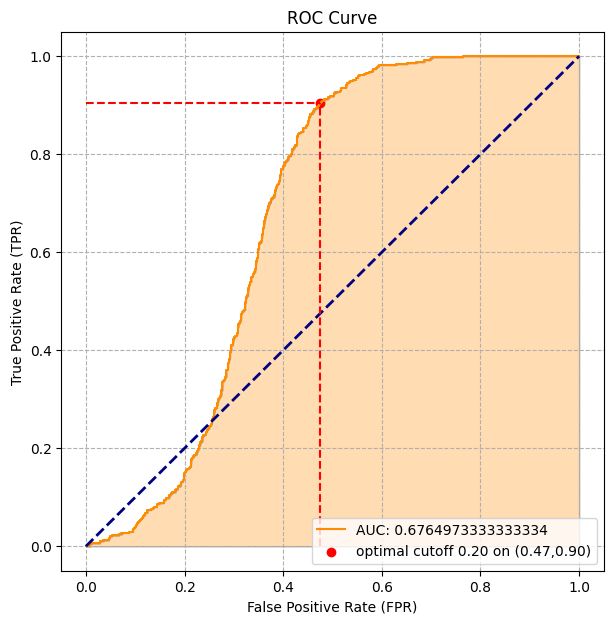

In [201]:
#ANTWOORD
data2 = data['price_range'].replace([0,2,3,1],[0,0,0,1])
# data2 = to_categorical(data2,4)
plot_roc(data2,data.predicted_price_range_proba )

# de AUC = 0.6764973333333334 

## b. 

In [202]:
#ANTWOORD 0.20 dit is het punt waar de verhouding tussen de TPR en FPR het hoogst is dus dit is het optimale punt om mee te werken


# Vraag 5


In [203]:
#ANTWOORD
#a. 3
#b. 3
#c. H1
#d.tanh

# Vraag 6

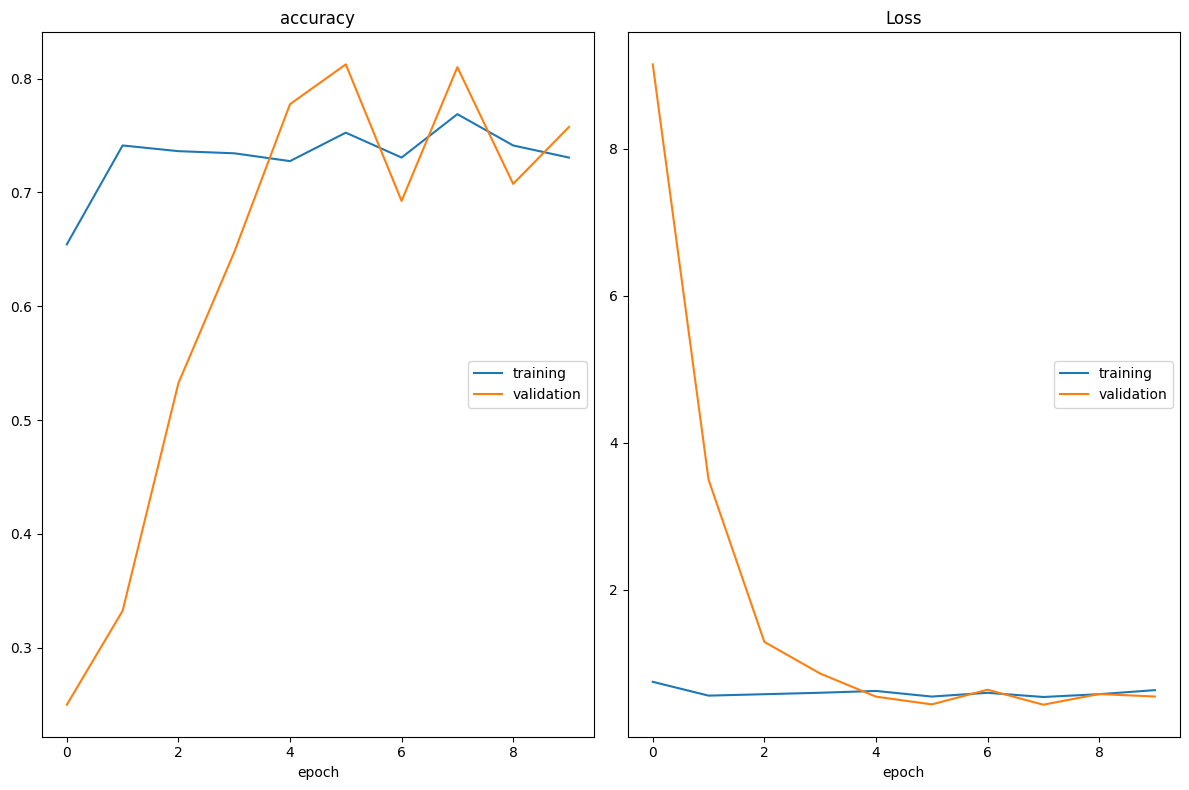

accuracy
	training         	 (min:    0.654, max:    0.769, cur:    0.731)
	validation       	 (min:    0.250, max:    0.812, cur:    0.757)
Loss
	training         	 (min:    0.544, max:    0.750, cur:    0.637)
	validation       	 (min:    0.439, max:    9.146, cur:    0.550)
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7549 - loss: 0.5745 - val_accuracy: 0.7575 - val_loss: 0.5503


In [204]:
#ANTWOORD
x = data[['battery_power','clock_speed','fc','int_memory','n_cores','pc','ram','talk_time']]
y= data['price_range']
y = to_categorical(y,4)
inputs = Input(shape=(8,))
x_and = BatchNormalization()(inputs)
x_and = Dense(8, activation='relu')(x_and)
outputs = Dense(4, activation='softmax')(x_and)

model = Model(inputs, outputs, name='model')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.10),loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])

history = model.fit(
    x,  # training data
    y,  # training targets
    epochs=10,
    batch_size=32,
   callbacks=[PlotLossesKeras()], 
    validation_split=0.2,
)


# Vraag 7 

In [205]:
import math

x1 = [1.0,0.5]
x2 = [-0.5,-0.5]
x3 = [1.0,1.0]
x4 = [-0.75,-0.75]
x5 = [-0.5,0.0]
x6 = [-0.5,-1.0]
x7 = [0.5,0.5]
x8 = [0.5,0.0]
x9 = [0.75,0.75]
x10 = [-1.2,-1.0]
xes = [x1,x2,x3,x4,x5,x6,x7,x8,x9,x10]
def energy(x):
    return((0.2 + x[0]*x[0] + x[0]*x[1] - 0.1 * np.cos(1.0*math.pi*x[0]) - 0.1 * np.cos(-2.0*np.pi*x[1])))



for i in xes:
    print(energy(i))

1.9000000000000001
0.7999999999999999
2.2
1.3957106781186548
0.35
0.85
0.7999999999999999
0.35
1.3957106781186548
2.8209016994374947


In [206]:
#ANTWOORD x10 want die heeft de grootste fitness

# Vraag 8

In [207]:
from random import Random

populatie = pd.DataFrame({'chromosoon':range(1,21), 'score_doelfunctie':[247.6251629 , 214.51757898, 249.13309669, 188.81888775,104.80883904, 316.12006777, 198.56246032, 465.06055288,156.80288596, 243.7813792 , 185.9045345 , 146.50208061, 119.45574293, 364.05258658, 416.80157775, 481.66470259, 412.22107183, 421.06760396, 227.18712982, 229.35077602]})
populatie


,chromosoon,score_doelfunctie
0,1,247.625163
1,2,214.517579
2,3,249.133097
3,4,188.818888
4,5,104.808839
5,6,316.120068
6,7,198.562460
7,8,465.060553
8,9,156.802886
9,10,243.781379


In [208]:
#ANTWOORD 20 want die heeft de laagste score en het is een minimalisatie probleem 



# Vraag 9 

In [209]:
#CEL 1: Startsituatie inlezen (NIETS AANPASSEN)
## 
from simanneal import Annealer
board = pd.read_csv('./sudoku.csv', header=None)

In [210]:
#CEL 2: emptyfields aanmaken (NIETS AANPASSEN)
# Code om de indexen van de lege velden in een list te steken [Niet aanpassen]
board_emptyFields = board == 0
emptyfields = np.where(board_emptyFields.to_numpy().flatten() == True)[0].tolist()  #De indices van de lege velden (velden met nul)

In [211]:
#CEL 3: Simulated annealing klasse
class Sudoku(Annealer): 
# ENGERGY FUNCTIE NIET AANPASSEN
 def energy(self):
    s = pd.DataFrame(self.state.reshape(9,9))
    lineTotal = 45
    lineSums = pd.concat([s.sum(axis=1), s.sum(axis=0)]) #Telt de som van de inhoud van de rijen en de kolommen 
    valueCounts = pd.Series(np.unique(s, return_counts=True))[1] #Telt hoe vaak elk getal voorkomt in een rij of kolom
    valueCountErrorCost=  np.absolute(valueCounts - 9).sum()*10
    lineValueErrorCost = np.absolute(lineSums - lineTotal).sum()*2
    return valueCountErrorCost + lineValueErrorCost

#ANTWOORD
 def move(self):
     i = np.random.randint(0,9)
     i2=np.random.randint(0,9)
     if (board[i][i2] == 0):
        self.state[i][i2] == np.random.randint(0,10)
    

sudoku = Sudoku(board.to_numpy())
sudoku.anneal()    


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


(array([[0, 0, 2, 4, 0, 1, 0, 0, 0],
        [0, 0, 0, 8, 0, 0, 0, 0, 0],
        [0, 9, 0, 3, 0, 6, 0, 0, 0],
        [0, 0, 0, 0, 0, 9, 0, 0, 0],
        [0, 0, 9, 0, 0, 0, 0, 5, 3],
        [1, 0, 0, 6, 0, 5, 0, 0, 0],
        [0, 2, 0, 7, 0, 0, 0, 8, 0],
        [0, 0, 8, 0, 0, 0, 0, 0, 1],
        [7, 0, 0, 0, 0, 0, 0, 0, 2]], dtype=int64),
 2306)